### Wetland delineation  
This notebook outlines the workflow for wetland delineation using data derived from GEE and applying Random classification model.

#### 1. Initial setup and GEE connection

#### 1.1 Install and import necessary libraries

In [1]:
import ee
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio     
import numpy as np  

from rasterio.warp import calculate_default_transform, reproject, Resampling

#### 1.2. Connect to GEE

In [2]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-ogalloethel") 

#### 1.3. Define AOI

In [3]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")

# Set AOI from shapefile
shapefile = gpd.read_file(os.path.join(base_dir, 'baringo_bbox/baringo_bbox.shp'))
study_area = ee.Geometry(shapefile.geometry[0].__geo_interface__)

Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


#### 2. Downloading data from GEE  
The necessary EO data downloaded include: DEM and slope, Land surface temperature, Derived NDVI and NDWI, Sentinel1-GRD data

#### 2.1 Generic functions to export GEE data

In [ ]:
# Function to read a raster file and return an aligned array
def clip_to_aoi(image):
    """
    Clip an ee.Image to the study_area geometry.
    Args:
        image (ee.Image): The image to clip.
    Returns:   
        ee.Image: The clipped image.
        """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")
    return image.clip(study_area)

# Function to export an ee.Image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """
    Export an ee.Image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the exported image.
        folder (str): The folder in Google Drive to save the image.
        scale (int): The scale of the exported image in meters.
    Returns:
        None
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Export started: {label}_{year}")


#### 2.1. Download DEM and SLope

In [ ]:
# Function to get DEM and slope
def get_dem():
    """
    Retrieve DEM and slope.

    Returns:
        Tuple[ee.Image, ee.Image]: (DEM image, slope image)
    """
    dem = ee.ImageCollection("COPERNICUS/DEM/GLO30") \
        .filterBounds(study_area).mosaic().select('DEM')
    dem = clip_to_aoi(dem).toFloat().reproject('EPSG:32736', 30)
    slope = ee.Terrain.slope(dem).rename('Slope')
    return dem.rename('DEM'), slope


In [ ]:
# Get DEM and slope
dem, slope = get_dem()

# Export or process each as needed
export_image_to_drive(dem, year='DEM', label='DEM', folder='DEM')
export_image_to_drive(slope, year='Slope', label='Slope', folder='DEM')

In [ ]:
# Function to reproject a raster to match another raster's CRS and dimensions
def reproject_to_match(src_path, ref_path, dst_path):
    """
    Reproject a raster to match the CRS, transform, and shape of a reference raster.
    Args:
        src_path (str): Path to source raster.
        ref_path (str): Path to reference raster.
        dst_path (str): Path to save reprojected raster.
    """
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst_array = np.empty((ref.height, ref.width), dtype=src.dtypes[0])
        reproject(
            source=src.read(1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref.transform,
            dst_crs=ref.crs,
            resampling=Resampling.bilinear
        )
        profile = src.profile.copy()
        profile.update({
            'crs': ref.crs,
            'transform': ref.transform,
            'width': ref.width,
            'height': ref.height
        })
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(dst_array, 1)

# Usage example:
reproject_to_match(
    src_path=os.path.join(base_dir, 'DEM', 'Slope.tif'),
    ref_path=os.path.join(base_dir, 'DEM', 'DEM.tif'),
    dst_path=os.path.join(base_dir, 'DEM', 'Slope_aligned.tif')
)


#### 2.2. Download Landsat Land Surface Temperature (LST) 2015-2025
A cloud mask was appled prior to download

In [ ]:
def cloud_mask(image):
    # Mask clouds and cloud shadows using QA_PIXEL band
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 5).eq(0))
    return image.updateMask(mask)

def download_lst(year):
    """
    Download Landsat 8 LST for a specific year.
    Args:
        year (int): The year for which to download the LST image.
    Returns:
        ee.Image: The mean LST image for the specified year.
    """
    lst_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterBounds(study_area)
               .filterDate(f'{year}-01-01', f'{year}-12-31')
               .map(cloud_mask)
               .map(lambda img: img.select('ST_B10')
                    .multiply(0.00341802).add(149.0)
                    .subtract(273.15)
                    .rename('LST'))
               .map(clip_to_aoi))
    return lst_col.mean().set({'year': year})


In [ ]:
# Loop through the years and export LST images
years = list(range(2015, 2026))

# Get the LST image for each year and export it to Google Drive
for year in years: 
    lst = download_lst(year)
    export_image_to_drive(lst, year, label='LST_mean', folder='LST')


#### 2.3. Compute NDVI Standard Deviation and Oscillation 2015-2025

In [ ]:
def compute_ndvi(year):
    """
    Compute NDVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute NDVI.
    Returns:   
        ee.Image: The NDVI standard deviation and range for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
          .select('NDVI'))

    ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}')
    ndvi_range = s2.reduce(ee.Reducer.max()).subtract(
        s2.reduce(ee.Reducer.min())
    ).rename(f'NDVI_Range_{year}')
    return ndvi_std, ndvi_range


In [ ]:
# Export NDVI statistics to Google Drive
for year in years:
    ndvi_std, ndvi_range = compute_ndvi(year)
    export_image_to_drive(ndvi_std, year, label='NDVI_SD', folder='NDVI')
    export_image_to_drive(ndvi_range, year, label='NDVI_Range', folder='NDVI')


#### 2.4. Compute max NDWI from S2 2015-2025

In [ ]:
def compute_ndwi(year):
    """
    Compute maximum NDWI for Sentinel-2 images for a given year.
    Args:
        year (int): Year of interest.
    Returns:
        ee.Image: Max NDWI image.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.normalizedDifference(['B8', 'B3'])
               .rename('NDWI').toFloat()))
    return s2.max().rename(f'NDWI_Max_{year}')


In [ ]:
# Export NDVI statistics 
for year in years:
    ndwi_max = compute_ndwi(year)
    export_image_to_drive(ndwi_max, year, label='NDWI_Max', folder='NDWI')

#### 2.5 Download S1 VV and VH GRD from 2015-2025

In [ ]:
def get_sentinel1_min(year, pol='VV', orbit_pass='ASCENDING'):
    """
    Get annual minimum Sentinel-1 backscatter (dB) for given polarization.

    Args:
        year (int): Year of interest.
        pol (str): Polarization ('VV' or 'VH').
        orbit_pass (str): Orbit pass ('ASCENDING' or 'DESCENDING').
    Returns:
        ee.Image: Minimum Sentinel-1 backscatter image for the specified year and polarization.
    """
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(study_area)
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', orbit_pass))
          .filter(ee.Filter.eq('resolution_meters', 10))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
          .select(pol))
    return clip_to_aoi(s1.min().rename(f'S1_{pol}_Min_{year}'))


In [ ]:
# Export Sentinel-1 VV and VH minimum backscatter images for each year
for year in years:
    for pol in ['VV', 'VH']:
        img = get_sentinel1_min(year, pol=pol)
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f'S1_{pol}_Min_{year}',
            folder=f'S1_{pol}',
            fileNamePrefix=f'S1_{pol}_Min_{year}',
            region=study_area,
            scale=10,
            crs='EPSG:4326',
            maxPixels=1e13
        )
        task.start()
        print(f"Started export: S1_{pol}_Min_{year}")


### 4. Feature clasification using Random Forest  

In [4]:
import os
import math
from collections import Counter

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.io import MemoryFile
from rasterio.transform import rowcol, from_bounds
from rasterio.features import geometry_mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.inspection import permutation_importance

from skimage.morphology import opening, square
from scipy.interpolate import griddata


#### 4.1 Training points 

In [5]:
# Define AOI extents
# Central point in decimal degrees
center_lat = 0.6
center_lon = 36.0667

# Define a bounding box: ±0.3° latitude (north-south), ±0.15° longitude (east-west)
lat_buffer = 0.3
lon_buffer = 0.15

# Compute extent (bounding box)
extent = (
    center_lon - lon_buffer,  # xmin (left)
    center_lat - lat_buffer,  # ymin (bottom)
    center_lon + lon_buffer,  # xmax (right)
    center_lat + lat_buffer   # ymax (top)
)

print("Computed extent:", extent)

# Load training points and reproject to match LST raster CRS if needed
gdf = gpd.read_file(os.path.join(base_dir, 'baringo_training_points.shp'))
with rasterio.open(os.path.join(base_dir, "DEM", "dem.tif")) as src:
    dem_crs = src.crs
if gdf.crs != dem_crs:
    gdf = gdf.to_crs(dem_crs)

gdf.head()


Computed extent: (35.9167, 0.3, 36.216699999999996, 0.8999999999999999)


,id,class,geometry
0,1,water,POINT (36.06711 0.56802)
1,2,water,POINT (36.04937 0.67043)
2,3,water,POINT (36.09725 0.47869)
3,4,water,POINT (36.09869 0.47104)
4,5,water,POINT (36.07187 0.34713)


#### 4.2 Stacking all the raster data  

Ensure all data are of the same shape before attempting to stack  

In [6]:
year = 2020

file_map = {
    "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
    "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
    "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
    "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
    "VV": os.path.join(base_dir, "S1_VV", f"S1_VV_Min_{year}.tif"),
    "VH": os.path.join(base_dir, "S1_VH", f"S1_VH_Min_{year}.tif"),
}

print(f"Raster shapes for year {year}:")
for name, path in file_map.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            print(f"{name}: {src.shape}")
    else:
        print(f"{name}: MISSING ({path})")


Raster shapes for year 2020:
LST: (2887, 3209)
NDWI: (2887, 3209)
NDVI_SD: (2887, 3209)
NDVI_range: (2887, 3209)
VV: (8660, 9625)
VH: (8660, 9625)


Cropping the raster data to the defined extents

In [7]:
from rasterio.windows import from_bounds

# DEM and slope (static)
dem_path = os.path.join(base_dir, "DEM", "DEM.tif")
slope_path = os.path.join(base_dir, "DEM", "Slope_aligned.tif")

# Prepare output dictionary
cropped_rasters_by_year = {}

for year in range(2015, 2026):
    year_data = {}

    # Temporal rasters 
    file_map = {
        "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
        "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
        "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
        "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
        "VV": os.path.join(base_dir, "S1_VV", f"S1_VV_Min_{year}.tif"),
        "VH": os.path.join(base_dir, "S1_VH", f"S1_VH_Min_{year}.tif"),
    }

    for name, path in file_map.items():
        if not os.path.exists(path):
            print(f"Missing: {path}")
            continue
        with rasterio.open(path) as src:
            window = from_bounds(*extent, transform=src.transform)
            arr = src.read(1, window=window)
            year_data[name] = arr

    # Static rasters 
    for path, name in zip([dem_path, slope_path], ["DEM", "Slope"]):
        with rasterio.open(path) as src:
            window = from_bounds(*extent, transform=src.transform)
            arr = src.read(1, window=window)
            year_data[name] = arr


    # Save year if at least some data exists
    if len(year_data) > 0:
        cropped_rasters_by_year[year] = year_data
    else:
        print(f"No data stored for {year}")

print("Cropping complete.")


Cropping complete.


resampling vv and vh to the same shape to match the rest of the rasters

In [9]:
def resample_to_ref(src_arr, src_path, dst_shape, dst_transform, dst_crs):
    with rasterio.open(src_path) as src:
        src_transform = src.window_transform(
            from_bounds(*extent, transform=src.transform)
        )
        src_crs = src.crs
        dst_arr = np.empty(dst_shape, dtype=src_arr.dtype)

        reproject(
            source=src_arr,
            destination=dst_arr,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )
    return dst_arr


# Reference raster info (DEM)
with rasterio.open(dem_path) as dem_src:
    window = from_bounds(*extent, transform=dem_src.transform)
    dem_transform = dem_src.window_transform(window)
    dem_crs = dem_src.crs

for year in cropped_rasters_by_year:
    dem_arr = cropped_rasters_by_year[year]["DEM"]
    dst_shape = dem_arr.shape

    for pol in ["VV", "VH"]:
        if pol in cropped_rasters_by_year[year]:
            src_arr = cropped_rasters_by_year[year][pol]
            src_path = os.path.join(base_dir, f"S1_{pol}", f"S1_{pol}_Min_{year}.tif")

            resampled_arr = resample_to_ref(src_arr, src_path, dst_shape, dem_transform, dem_crs)
            cropped_rasters_by_year[year][pol] = resampled_arr

print("Resampling VV/VH complete.")


Resampling VV/VH complete.


Visualizing the rasters

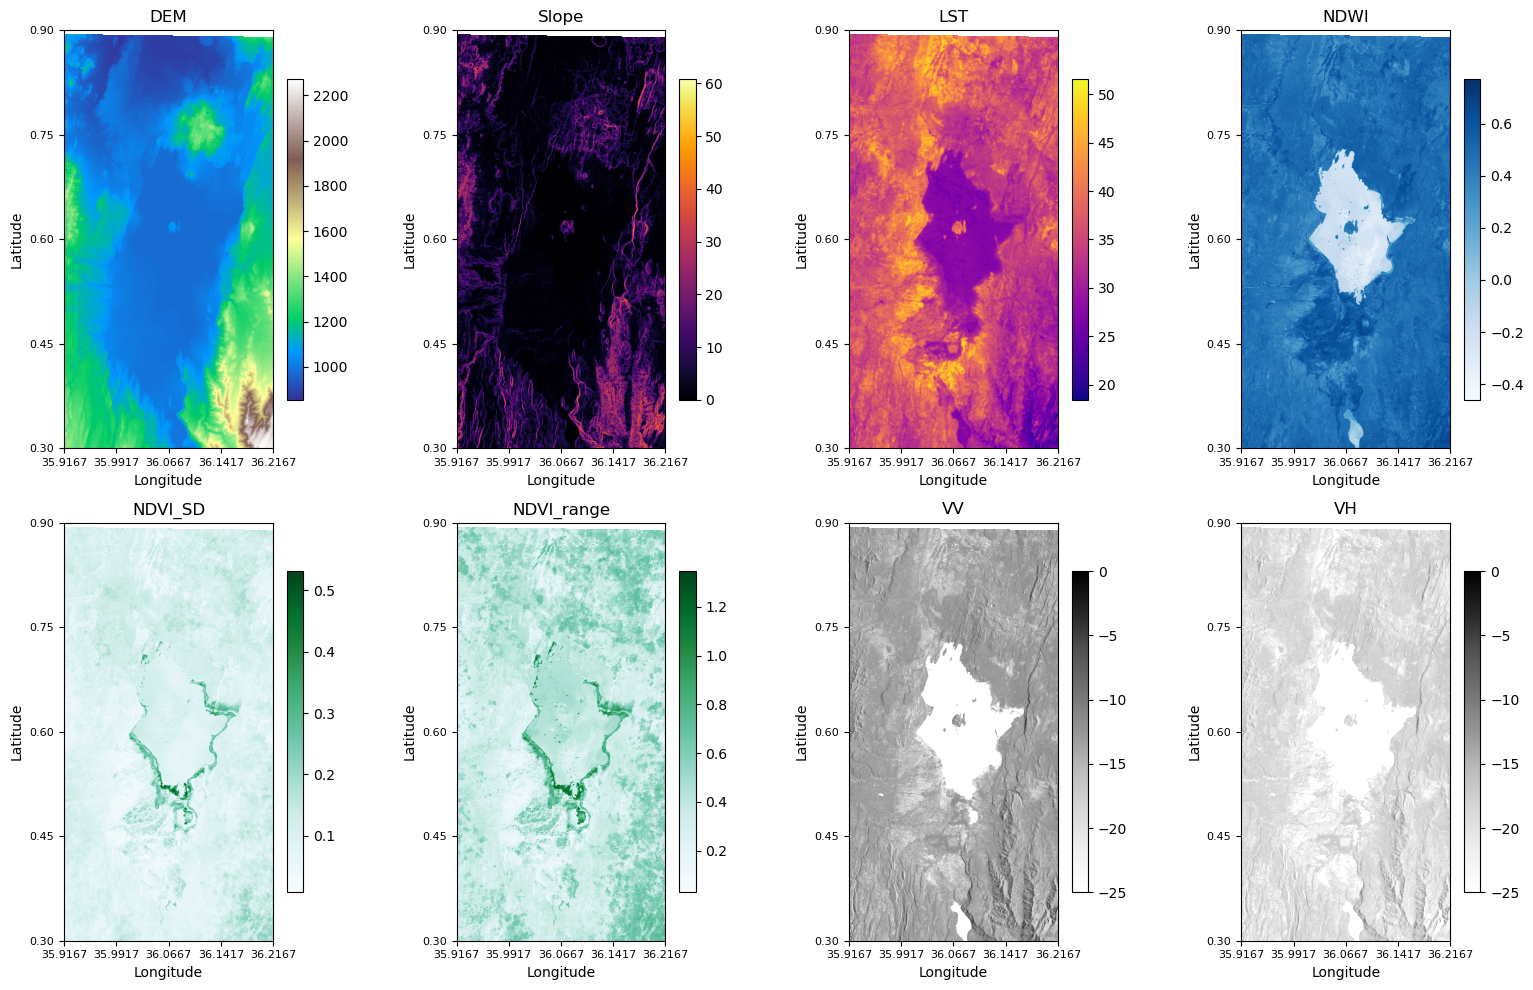

In [10]:
layer_data = cropped_rasters_by_year[2020]

layers_to_plot = ["DEM", "Slope", "LST", "NDWI", "NDVI_SD", "NDVI_range", "VV", "VH"]
colormaps = {
    "DEM": "terrain", "Slope": "inferno", "LST": "plasma", "NDWI": "Blues",
    "NDVI_SD": "BuGn", "NDVI_range": "BuGn", "VV": "Greys", "VH": "Greys"
}

nrows = 2
ncols = -(-len(layers_to_plot) // nrows)  # ceiling division 
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))
axes = axes.flatten()
xmin, ymin, xmax, ymax = extent

for ax, name in zip(axes, layers_to_plot):
    if name in layer_data:
        # For VV and VH, set color limits for dB range
        if name in ["VV", "VH"]:
            vmin, vmax = -25, 0  # typical SAR dB range, adjust if needed
            img = ax.imshow(layer_data[name], cmap=colormaps.get(name, "viridis"),
                            extent=[xmin, xmax, ymin, ymax], origin='upper',
                            vmin=vmin, vmax=vmax)
        else:
            img = ax.imshow(layer_data[name], cmap=colormaps.get(name, "viridis"),
                            extent=[xmin, xmax, ymin, ymax], origin='upper')
        
        ax.set_title(name)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        xticks = np.linspace(xmin, xmax, 5)
        yticks = np.linspace(ymin, ymax, 5)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.tick_params(axis='both', which='major', labelsize=8)

        fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.axis('off')
        print(f"{name} missing for 2020")


for ax in axes[len(layers_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Stacking all the raster data into a single multi-band raster and ensuring they are within the AOI


In [11]:
feature_stack_by_year = {}

# Extract static layers (DEM and Slope) once
static_layers = {}
for name in ["DEM", "Slope"]:
    static_arr = cropped_rasters_by_year[2025].get(name)  # Any year works since they're static
    if static_arr is not None:
        static_layers[name] = static_arr
    else:
        print(f"Static layer '{name}' not found in cropped data.")

# Stack temporal + static layers per year
for year in range(2015, 2026):
    year_data = cropped_rasters_by_year.get(year, {})
    layers, layer_names = [], []

    # Temporal layers (year-specific)
    temporal_names = ["LST", "NDWI", "NDVI_SD", "NDVI_range", "VV", "VH"]
    for name in temporal_names:
        arr = year_data.get(name)
        if arr is not None:
            layers.append(arr)
            layer_names.append(name)

    # Add static layers
    for name, arr in static_layers.items():
        if arr is not None:
            layers.append(arr)
            layer_names.append(name)

    # Check for consistent shapes and stack
    if len(layers) >= 2 and len(set(arr.shape for arr in layers)) == 1:
        feature_stack_by_year[year] = {
            "stack": np.stack(layers, axis=-1),
            "layer_names": layer_names
        }
    else:
        print(f"Year {year}: Missing or mismatched layers, skipped.")


extracting pixel values at the training points 

In [12]:
# Get cropped transform once from DEM using extent
with rasterio.open(dem_path) as src:
    window = from_bounds(*extent, transform=src.transform)
    cropped_transform = src.window_transform(window)

# Prepare coords
coords = [(geom.x, geom.y) for geom in gdf.geometry]

if 'training_data_by_year' not in globals():
    training_data_by_year = {}

for year in feature_stack_by_year:
    feature_stack = feature_stack_by_year[year]['stack']
    transform = cropped_transform  # fixed for all years since cropping extent is same

    rows_cols = [rowcol(transform, x, y) for x, y in coords]

    pixels, labels = [], []
    for (row, col), label in zip(rows_cols, gdf["class"]):
        if 0 <= row < feature_stack.shape[0] and 0 <= col < feature_stack.shape[1]:
            px = feature_stack[row, col, :]
            if not np.any(np.isnan(px)):
                pixels.append(px)
                labels.append(label)

    X = np.array(pixels)
    y = np.array(labels)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    training_data_by_year[year] = {"X": X, "y": y_encoded, "label_encoder": le}

    print(f"Year {year}: {len(y)} samples")


Year 2015: 75 samples
Year 2016: 75 samples
Year 2017: 75 samples
Year 2018: 75 samples
Year 2019: 75 samples
Year 2020: 75 samples
Year 2021: 75 samples
Year 2022: 75 samples
Year 2023: 75 samples
Year 2024: 75 samples
Year 2025: 75 samples


In [13]:
year = 2020
df_samples = pd.DataFrame(training_data_by_year[year]['X'], columns=layer_names)
df_samples['class'] = training_data_by_year[year]['y']
df_samples.iloc[:-10]

,LST,NDWI,NDVI_SD,NDVI_range,VV,VH,DEM,Slope,class
0,27.191060,-0.262071,0.085111,0.351213,-30.549434,-37.320474,973.000000,0.000000,2
1,25.615673,-0.214967,0.112453,0.456827,-28.480604,-36.581710,973.000000,0.000000,2
2,27.631878,0.467113,0.164598,0.870581,-27.010121,-34.865595,978.000000,0.000000,2
3,30.020006,0.620334,0.030479,0.136638,-14.666354,-19.937652,978.527100,0.265356,2
4,26.643190,0.238816,0.076593,0.339815,-28.451233,-35.641219,995.757324,0.464091,2
...,...,...,...,...,...,...,...,...,...
60,32.169325,0.602708,0.035280,0.140680,-15.698984,-20.352275,1007.488831,0.351558,3
61,33.025086,0.557671,0.031242,0.108748,-17.159700,-22.015522,1006.782166,0.407130,3
62,31.789686,0.635135,0.036554,0.133371,-16.413605,-21.238023,1007.281799,0.245018,3
63,31.143893,0.550960,0.035582,0.184891,-16.982933,-22.394302,1004.799683,0.318497,3


#### 4.3 Stratified 5-fold Cross validation with Random Forest  
Training the random forest model using the training dataset 


Combined Train/Test and Cross validation training of the model

In [14]:
def train_model_per_year(year, training_data, test_size=0.2, n_estimators_cv=100, n_estimators_final=200, random_state=42):
    """
    Train Random Forest model for each year with train/test split and cross-validation.
    
    Returns:
        model: final trained model on combined train+val
        metrics: dict with CV and test accuracies and predictions
    """
    data = training_data[year]
    X, y, le = data["X"], data["y"], data["label_encoder"]

    # Split into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Cross-validation training
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_true, cv_pred = [], []
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        rf = RandomForestClassifier(n_estimators=n_estimators_cv, random_state=random_state)
        rf.fit(X_train_val[train_idx], y_train_val[train_idx])
        y_val_pred = rf.predict(X_train_val[val_idx])
        cv_true.extend(y_train_val[val_idx])
        cv_pred.extend(y_val_pred)

    cv_accuracy = accuracy_score(cv_true, cv_pred)

    # Final model on combined train+val
    final_rf = RandomForestClassifier(n_estimators=n_estimators_final, random_state=random_state)
    final_rf.fit(X_train_val, y_train_val)

    # Test set evaluation
    y_test_pred = final_rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    metrics = {
        "cv_true": cv_true,
        "cv_pred": cv_pred,
        "cv_accuracy": cv_accuracy,
        "y_test": y_test,
        "y_test_pred": y_test_pred,
        "test_accuracy": test_accuracy,
        "label_encoder": le,
    }

    return final_rf, metrics

#### 4.4 Prediction   
Prediction of the wetland classess based on the model and estimation of area covered by each class in Ha

In [ ]:
# Train model for a specific year
def prediction_per_year(year, model, feature_stack_by_year, extent, label_encoder):
    """
    Predict classification raster for one year and compute area per class.
    
    Returns:
        pred_img: 2D numpy array of predictions with -1 outside AOI
        class_areas: dict of class names to area in hectares
    """
    feature_stack = feature_stack_by_year[year]["stack"]
    flat = feature_stack.reshape(-1, feature_stack.shape[-1])
    valid_mask = ~np.isnan(flat).any(axis=1)

    pred = np.full(flat.shape[0], -1, dtype=int)
    pred[valid_mask] = model.predict(flat[valid_mask])
    pred_img = pred.reshape(feature_stack.shape[:2])

    counts = Counter(pred_img[pred_img >= 0])

    # Calculate pixel area in hectares
    lat = (extent[1] + extent[3]) / 2
    deg_to_m = 111320  # meters per degree
    pixel_w = abs(extent[2] - extent[0]) / pred_img.shape[1]
    pixel_h = abs(extent[3] - extent[1]) / pred_img.shape[0]
    pixel_area_ha = (pixel_w * deg_to_m * math.cos(math.radians(lat))) * (pixel_h * deg_to_m) / 10_000

    class_areas = {
        label_encoder.inverse_transform([cls])[0]: count * pixel_area_ha for cls, count in counts.items()
    }

    return pred_img, class_areas

In [16]:
models_by_year = {}
metrics_by_year = {}
predictions_by_year = {}

for year in sorted(training_data_by_year.keys()):
    print(f"\nProcessing year {year}...")

    # Train model
    model, metrics = train_model_per_year(year, training_data_by_year)
    models_by_year[year] = model
    metrics_by_year[year] = metrics

    print(f"Year {year} CV Accuracy: {metrics['cv_accuracy']:.4f}")
    print(f"Year {year} Test Accuracy: {metrics['test_accuracy']:.4f}")

    # Predict
    pred_img, class_areas = prediction_per_year(year, model, feature_stack_by_year, extent, metrics["label_encoder"])
    predictions_by_year[year] = {
        "pred_img": pred_img,
        "class_areas": class_areas,
    }

    print(f"Prediction complete for year {year}.")                



Processing year 2015...
Year 2015 CV Accuracy: 0.8667
Year 2015 Test Accuracy: 0.9333
Prediction complete for year 2015.

Processing year 2016...
Year 2016 CV Accuracy: 0.8167
Year 2016 Test Accuracy: 0.9333
Prediction complete for year 2016.

Processing year 2017...
Year 2017 CV Accuracy: 0.8333
Year 2017 Test Accuracy: 0.8667
Prediction complete for year 2017.

Processing year 2018...
Year 2018 CV Accuracy: 0.8500
Year 2018 Test Accuracy: 0.8000
Prediction complete for year 2018.

Processing year 2019...
Year 2019 CV Accuracy: 0.8500
Year 2019 Test Accuracy: 0.8667
Prediction complete for year 2019.

Processing year 2020...
Year 2020 CV Accuracy: 0.8500
Year 2020 Test Accuracy: 0.8667
Prediction complete for year 2020.

Processing year 2021...
Year 2021 CV Accuracy: 0.8667
Year 2021 Test Accuracy: 0.8667
Prediction complete for year 2021.

Processing year 2022...
Year 2022 CV Accuracy: 0.9333
Year 2022 Test Accuracy: 0.8667
Prediction complete for year 2022.

Processing year 2023...


=== 2015 Test set Classification Report ===
              precision    recall  f1-score   support

      forest       1.00      1.00      1.00         3
   rangeland       0.67      1.00      0.80         2
       water       1.00      1.00      1.00         4
     wetland       1.00      0.83      0.91         6

    accuracy                           0.93        15
   macro avg       0.92      0.96      0.93        15
weighted avg       0.96      0.93      0.94        15



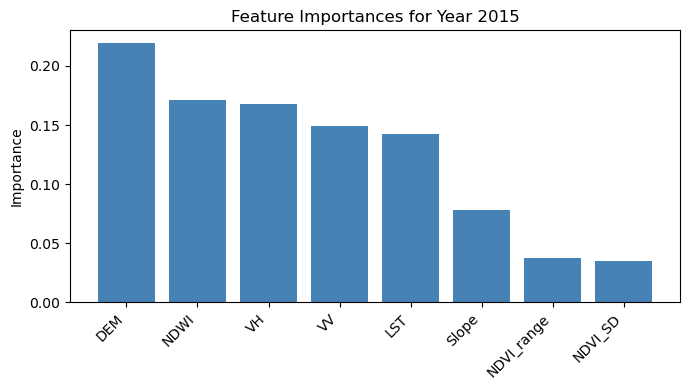

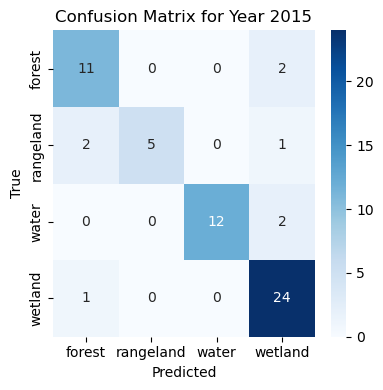


Estimated area per class for year 2015:
  forest: 80055.79 ha
  rangeland: 54570.41 ha
  wetland: 64823.06 ha
  water: 21023.80 ha


In [27]:
import seaborn as sns

year = 2015  # change as needed

le = metrics_by_year[year]['label_encoder']
y_test = metrics_by_year[year]['y_test']
y_test_pred = metrics_by_year[year]['y_test_pred']

print(f"\n=== {year} Test set Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Assuming you have your trained RF model
rf_model = models_by_year[year]

# Define feature names yourself here (match your actual feature stack order)
features = ['LST', 'NDWI', 'NDVI_SD', 'NDVI_range', 'VV', 'VH', 'DEM', 'Slope']

importances = rf_model.feature_importances_
idx = importances.argsort()[::-1]

plt.figure(figsize=(7, 4))
plt.bar(np.array(features)[idx], importances[idx], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title(f"Feature Importances for Year {year}")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Plot confusion matrix
cv_true = metrics_by_year[year]['cv_true']
cv_pred = metrics_by_year[year]['cv_pred']
cm = confusion_matrix(cv_true, cv_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Year {year}')
plt.tight_layout()
plt.show()

print(f"\nEstimated area per class for year {year}:")
for cls, area in predictions_by_year[year]['class_areas'].items():
    print(f"  {cls}: {area:.2f} ha")


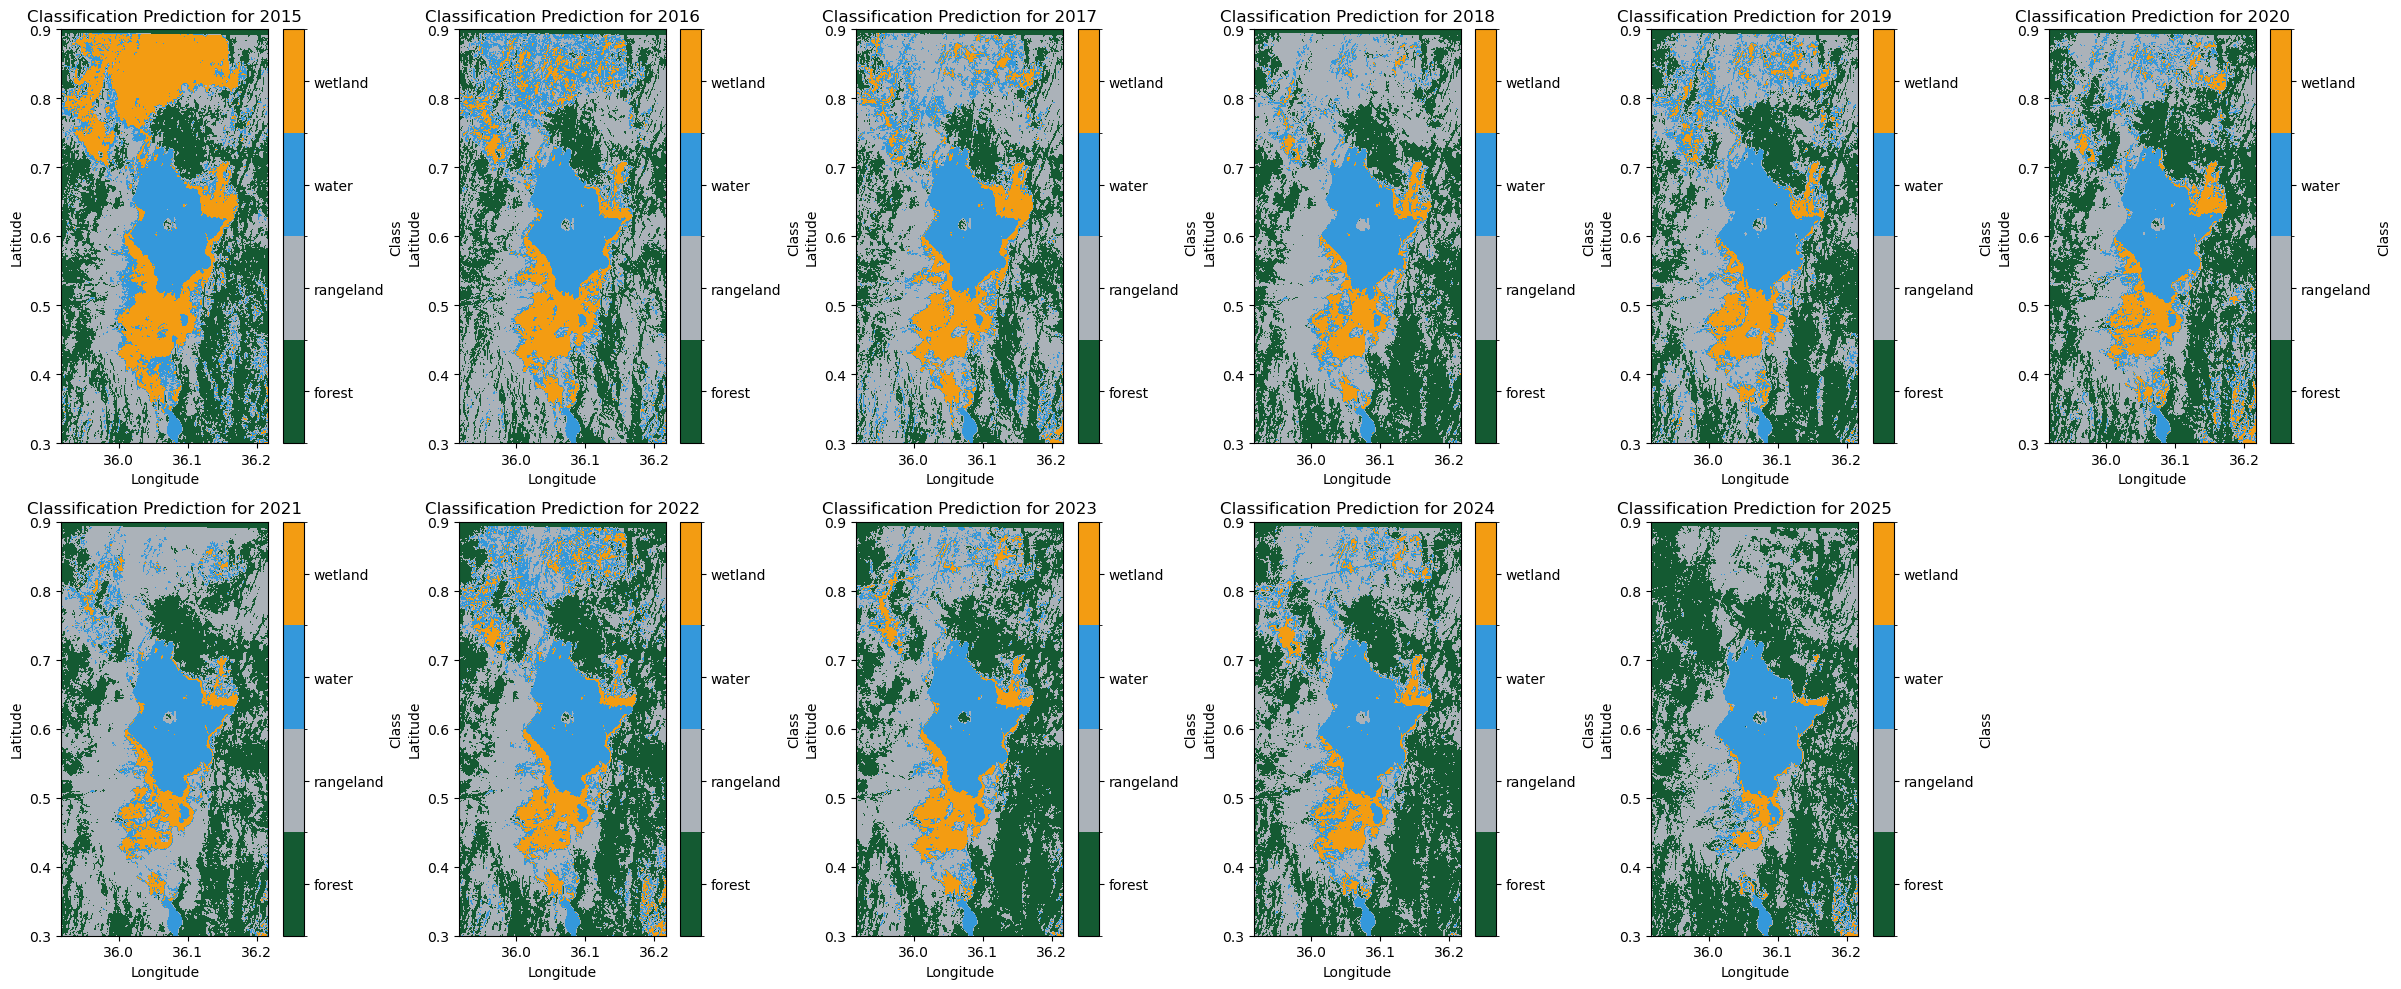

In [35]:
years = sorted(predictions_by_year.keys())  
n_years = len(years)

# Setup colormap and norm once (assuming same classes all years)
le = metrics_by_year[years[0]]['label_encoder']
labels = le.classes_
cmap = ListedColormap(['#145a32', '#abb2b9', '#3498db', '#f39c12'][:len(labels)])
norm = BoundaryNorm(np.arange(len(labels)+1)-0.5, cmap.N)
extent = (xmin, xmax, ymin, ymax)


# Define subplot grid size (2 rows, adjust columns)
nrows = 2
ncols = (n_years + 1) // 2

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 5*nrows))
axes = axes.flatten()

for ax, year in zip(axes, years):
    pred_img = predictions_by_year[year]['pred_img']

    im = ax.imshow(pred_img, cmap=cmap, norm=norm, extent=extent, origin='upper')
    ax.set_title(f"Classification Prediction for {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')

    # Add colorbar per subplot (optional: can add one global colorbar outside loop)
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(len(labels)))
    cbar.ax.set_yticklabels(labels)
    cbar.set_label("Class")

# Remove empty subplots if any
for ax in axes[n_years:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
